# Tuning and Optimizing Neural Networks - Lab

## Introduction

Now that you've seen some regularization, initialization and optimization techniques, its time to synthesize those concepts into a cohesive modeling pipeline.  

With this pipeline, you will not only fit an initial model but will also attempt to set various hyperparameters for regularization techniques. Your final model selection will pertain to the test metrics across these models. This will more naturally simulate a problem you might be faced with in practice, and the various modeling decisions you are apt to encounter along the way.  

Recall that our end objective is to achieve a balance between overfitting and underfitting. You've seen the bias variance trade-off, and the role of regularization in order to reduce overfitting on training data and improving generalization to new cases. Common frameworks for such a procedure include train/validate/test methodology when data is plentiful, and K-folds cross-validation for smaller, more limited datasets. In this lab, you'll perform the latter, as the dataset in question is fairly limited. 

## Objectives

You will be able to:

* Implement a K-folds cross validation modeling pipeline
* Apply normalization as a preprocessing technique
* Apply regularization techniques to improve your model's generalization
* Choose an appropriate optimization strategy 

## Loading the Data

Load and preview the dataset below.

In [1]:
# Your code here; load and preview the dataset
import pandas as pd

data = pd.read_csv("loan_final.csv", header=0)

# drop rows with no label
data.dropna(subset=['total_pymnt'],inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42535 entries, 0 to 42537
Data columns (total 16 columns):
loan_amnt              42535 non-null float64
funded_amnt_inv        42535 non-null float64
term                   42535 non-null object
int_rate               42535 non-null object
installment            42535 non-null float64
grade                  42535 non-null object
emp_length             41423 non-null object
home_ownership         42535 non-null object
annual_inc             42531 non-null float64
verification_status    42535 non-null object
loan_status            42535 non-null object
purpose                42535 non-null object
addr_state             42535 non-null object
total_acc              42506 non-null float64
total_pymnt            42535 non-null float64
application_type       42535 non-null object
dtypes: float64(6), object(10)
memory usage: 5.5+ MB


## Defining the Problem

Set up the problem by defining X and y. 

For this problem use the following variables for X:
* loan_amnt
* home_ownership
* funded_amnt_inv
* verification_status
* emp_length
* installment
* annual_inc

Our target variable y will be ```total_pymnt```

In [2]:
# Your code here; appropriately define X and y
import numpy as np

features = ['loan_amnt', 'funded_amnt_inv', 'installment', 'annual_inc', 'home_ownership', 'verification_status', 'emp_length']

X = data.loc[:, features]
y = data.loc[:, 'total_pymnt']


### Preprocessing Steps
* Fill in missing values with SimpleImputer
* Standardize continuous features with StandardScalar()
* One hot encode categorical features with OneHotEncoder()

In [3]:
from sklearn.preprocessing import StandardScaler
columns = []
for i in X.columns:
    if (X[i].dtype) == object:
        dummies = pd.get_dummies(X[i])
        X = X.drop(columns=i)
        for i in dummies.columns:
            X[i] = dummies[i]
            columns.append(i)
    else:
        columns.append(i)
    
    
X = X.fillna(0)
scaler = StandardScaler()
scaler.fit(X)
X =scaler.transform(X)
np.shape(X)

(42535, 23)

## Generating a Hold Out Test Set

While we will be using K-fold cross validation to select an optimal model, we still want a final hold out test set that is completely independent of any modeling decisions. As such, pull out a sample of 10% of the total available data. For consistency of results, use random seed 123. 

In [4]:
# Your code here; generate a hold out test set for final model evaluation. Use random seed 123.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

In [5]:

X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)

## Defining a K-fold Cross Validation Methodology

Now that your have a complete holdout test set, write a function that takes in the remaining data and performs k-folds cross validation given a model object. 

> Note: Think about how you will analyze the output of your models in order to select an optimal model. This may involve graphs, although alternative approaches are certainly feasible.

In [6]:
# Your code here; define a function to evaluate a model object using K folds cross validation.
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def k_folds(features_train, labels_train, model_obj, k=10, n_epochs=100):
    colors = sns.color_palette("Set2")

    validation_scores = []
    
    kf = KFold(n_splits=10, shuffle=True)
    
    fig, axes = plt.subplots(2, 5, figsize=(12,8))
    for i, (train_index, test_index) in enumerate(kf.split(features_train)):
        "Currently graph imaging assumes 10 folds and is hardcoded to 5x2 layout."
        
        row = i//5
        col = i%5
        
        X_train, X_val = features_train.iloc[train_index], features_train.iloc[test_index]
        y_train, y_val = labels_train.iloc[train_index], labels_train.iloc[test_index]
        
        model = model_obj
        
        hist = model.fit(X_train, y_train, batch_size=32,
                         epochs=n_epochs, verbose=0, validation_data = (X_val, y_val))
        #Note: verboxe=0 turns off printouts regarding training for each epoch.
        #Potential simpler methodology
        validation_score = model.evaluate(X_val, y_val)
        validation_scores.append(validation_score)
        ax = axes[row, col]
        k = 'val_loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[0])

        k = 'loss'
        d = hist.history[k]
        ax.plot(d, label=k, color=colors[1])
        ax.set_title('Fold {} Validation'.format(i+1))
        
    #Final Graph Formatting
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    plt.legend(bbox_to_anchor=(1,1))
    
    #General Overview
    validation_score = np.average(validation_scores)
    print('Mean Validation Score:', validation_score)
    print('Standard Deviation of Validation Scores:', np.std(validation_scores))
    return validation_score

## Building a Baseline Model

Here, it is also important to define your evaluation metric that you will look to optimize while tuning the model. Additionally, model training to optimize this metric may consist of using a validation and test set if data is plentiful, or k-folds cross-validation if data is limited. Since this dataset is not overly large, it will be most appropriate to set up a k-folds cross-validation  

In [7]:
# Your code here; define and compile an initial model as described
from keras.models import Sequential
from keras.layers import Dense

np.random.seed(123)
model = Sequential()
model.add(Dense(7, input_dim=23, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer= "adam" ,loss='mse',metrics=['mse'])

Using TensorFlow backend.


## Evaluating the Baseline Model with K-Folds Cross Validation

Use your k-folds function to evaluate the baseline model.  

Note: This code block is likely to take 10-20 minutes to run depending on the specs on your computer.
Because of time dependencies, it can be interesting to begin timing these operations for future reference.

Here's a simple little recipe to achieve this:
```
import time
import datetime

now = datetime.datetime.now()
later = datetime.datetime.now()
elapsed = later - now
print('Time Elapsed:', elapsed)
```

3190/3190 [==============================] - 0s 20us/step
Mean Validation Score: 15895138.893297601
Standard Deviation of Validation Scores: 1140587.7620662143


15895138.893297601

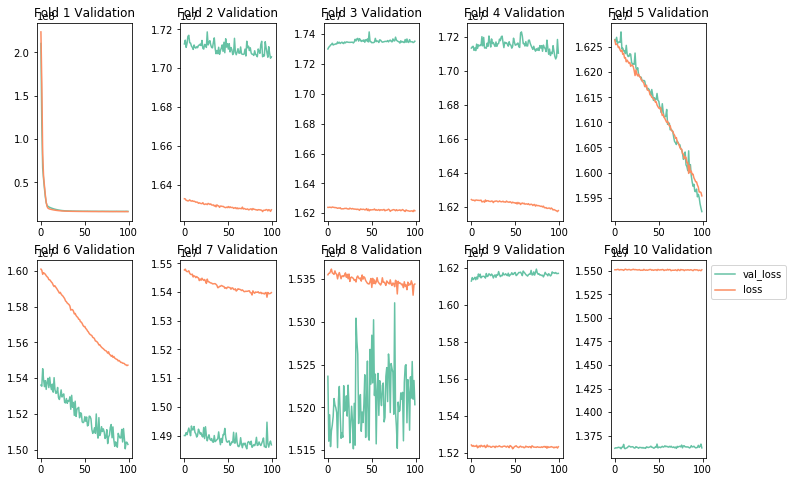

In [8]:
# Your code here; use your k-folds function to evaluate the baseline model.
# ⏰ This cell may take several mintes to run
k_folds(X_train, y_train, model)

## Intentionally Overfitting a Model

Now that you've developed a baseline model, its time to intentionally overfit a model. To overfit a model, you can:
* Add layers
* Make the layers bigger
* Increase the number of training epochs

Again, be careful here. Think about the limitations of your resources, both in terms of your computers specs and how much time and patience you have to let the process run. Also keep in mind that you will then be regularizing these overfit models, meaning another round of experiments and more time and resources.

3190/3190 [==============================] - 0s 21us/step
Mean Validation Score: 15469842.409160357
Standard Deviation of Validation Scores: 1263731.4621239025
Time Elapsed: 1249.803184747696


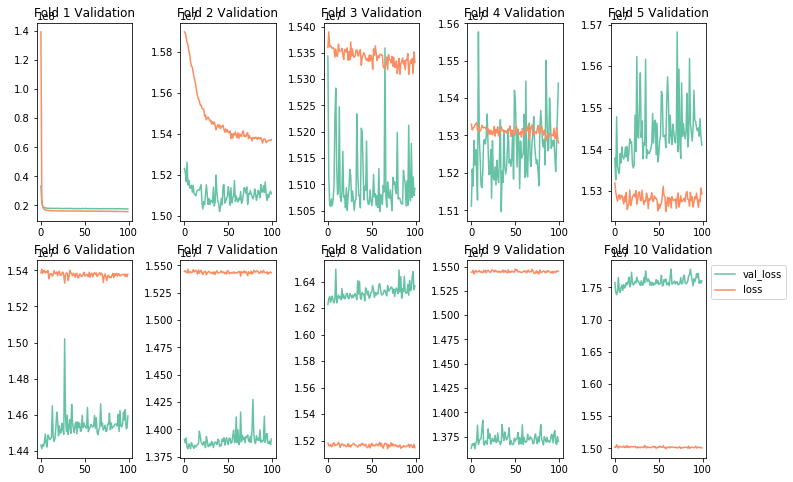

In [9]:
# Your code here; try some methods to overfit your network
# ⏰ This cell may take several mintes to run
# Timing Notes: On a top of the line mac-book pro, using our 10 fold cross validation methodology,
# a 5-layer neural network with 10 units per hidden layer and 100 epochs took ~15 minutes to train and validate
import time
now = time.time()

input_dim = X_train.shape[1]

#Model Mod 1: Adding More Layers
model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer= "adam" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model)   

later = time.time()
elapsed = later - now
print('Time Elapsed:', elapsed)


3190/3190 [==============================] - 0s 25us/step
Mean Validation Score: 15300344.999768054
Standard Deviation of Validation Scores: 1548645.796389309
Time Elapsed: 1284.1009781360626


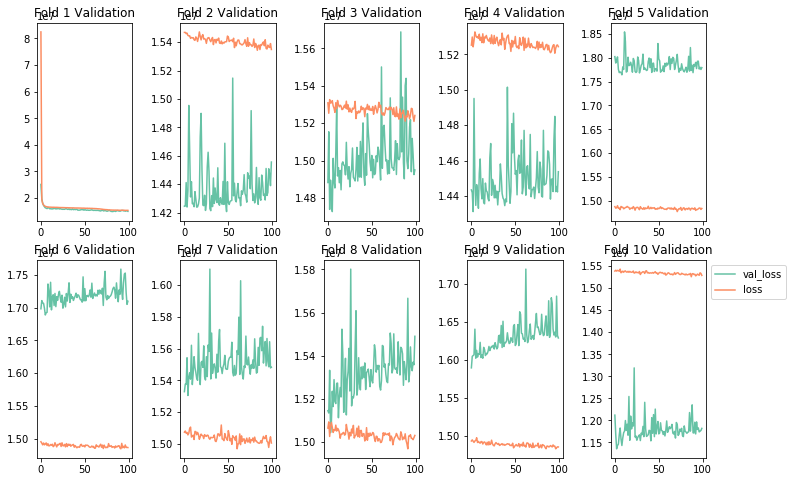

In [10]:
# Your code here; try some methods to overfit your network
# Model Mod 2: More Layers and Bigger Layers
# Timing Notes: On a top of the line mac-book pro, using our 10 fold cross validation methodology,
# a 5-layer neural network with 25 units per hidden layer and 100 epochs took ~25 minutes to train and validate

now = time.time()

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer= "adam" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model)  

later = time.time()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 23us/step
Mean Validation Score: 15350560.680735057
Standard Deviation of Validation Scores: 733583.1963369354
Time Elapsed: 5775.139266252518


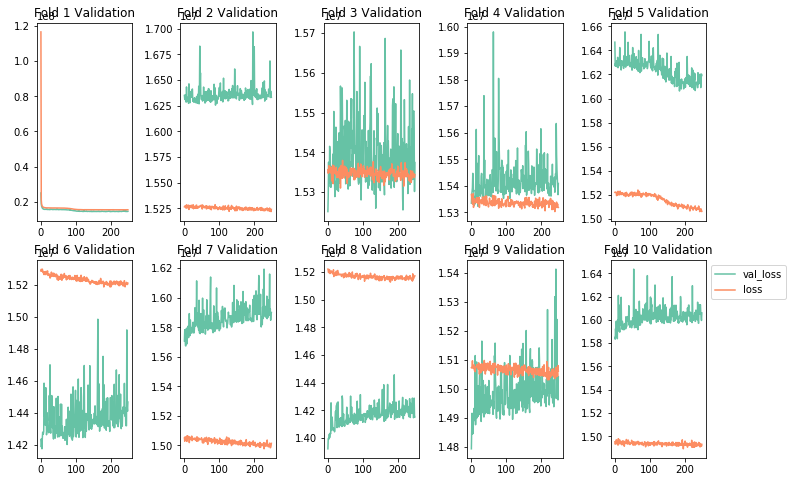

In [11]:
# Your code here; try some methods to overfit your network
# Model Mod 3: More Layers, More Epochs 
# Timing Notes: On a top of the line mac-book pro, using our 10 fold cross validation methodology,
# a 5-layer neural network with 10 units per hidden layer and 250 epochs took ~45 minutes to train and validate

now = time.time()

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer= "adam" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=250)

later = time.time()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Regularizing the Model to Achieve Balance  

Now that you have a powerful model (albeit an overfit one), we can now increase the generalization of the model by using some of the regularization techniques we discussed. Some options you have to try include:  
* Adding dropout
* Adding L1/L2 regularization
* Altering the layer architecture (add or remove layers similar to above)  

This process will be constrained by time and resources. Be sure to test at least 2 different methodologies, such as dropout and L2 regularization. If you have the time, feel free to continue experimenting.

Notes: 

3190/3190 [==============================] - 0s 24us/step
Mean Validation Score: 15364464.332920277
Standard Deviation of Validation Scores: 1194973.5283124298
Time Elapsed: 3320.504018306732


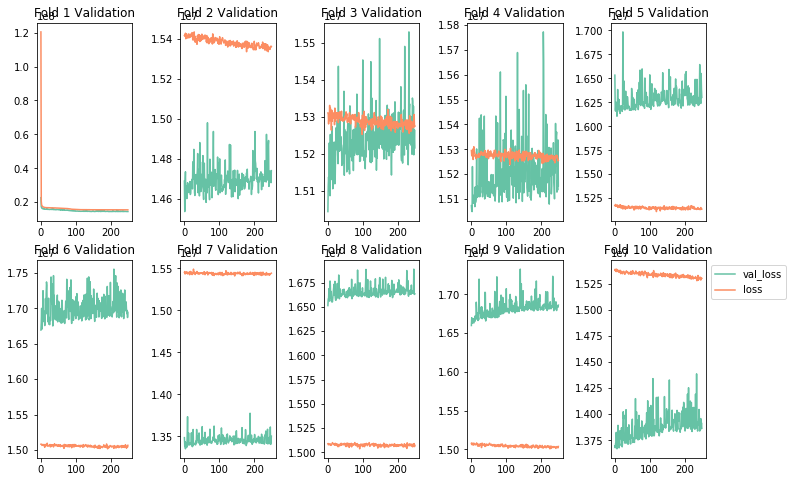

In [12]:
# Your code here; try some regularization or other methods to tune your network
# L1 Regularization
from keras import regularizers

#kernel_regularizer=regularizers.l1(0.005)
#kernel_regularizer=regularizers.l2(0.005)
#model.add(layers.Dropout(0.3))

now = time.time()

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer= "adam" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=250) 

later = time.time()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 46us/step
Mean Validation Score: 15407612.937285135
Standard Deviation of Validation Scores: 1185645.409520072
Time Elapsed: 3013.517965078354


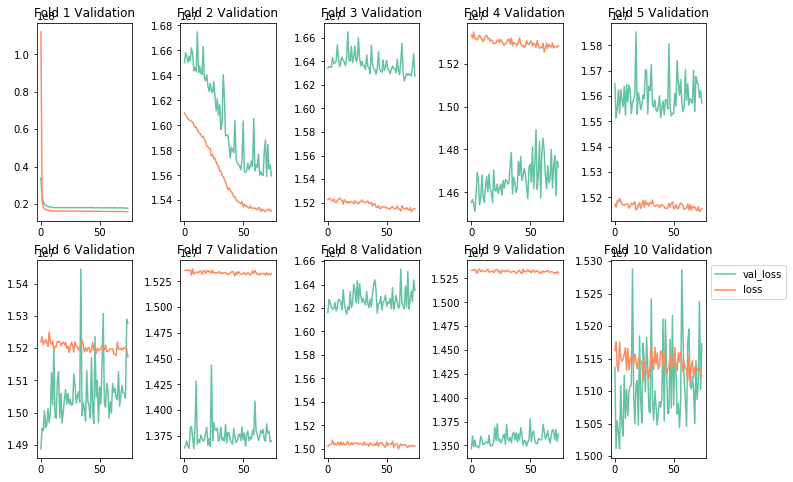

In [14]:
# Your code here; try some regularization or other methods to tune your network
# L2 Regularization and Early Stopping
now = time.time()

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer= "adam" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, n_epochs=75) 

later = time.time()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 28us/step
Mean Validation Score: 19028470.942253664
Standard Deviation of Validation Scores: 1520705.7888870917
Time Elapsed: 1239.9202644824982


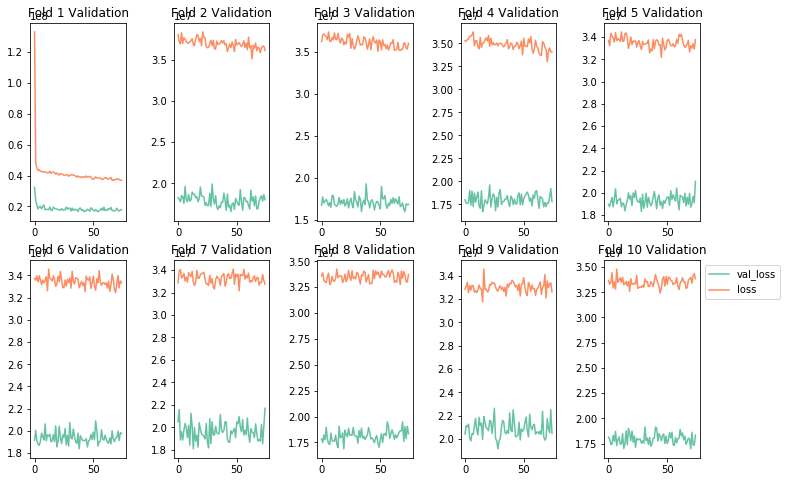

In [16]:
# Your code here; try some regularization or other methods to tune your network
# Dropout and Early Stopping
from keras import layers

now = time.time()

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer= "adam" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, k=5, n_epochs=75) 

later = time.time()
elapsed = later - now
print('Time Elapsed:', elapsed)

3190/3190 [==============================] - 0s 30us/step
Mean Validation Score: 18853151.852504082
Standard Deviation of Validation Scores: 721858.2231592309
Time Elapsed: 1271.7449538707733


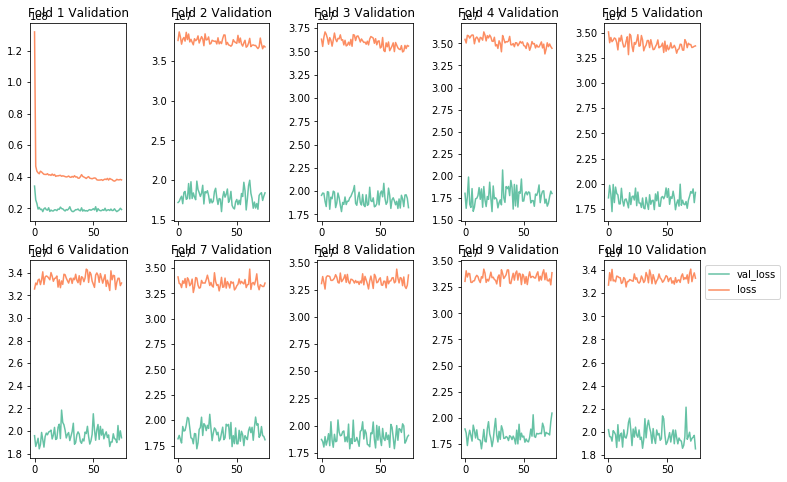

In [17]:
# Your code here; try some regularization or other methods to tune your network
# L1, Dropout and Early Stopping

now = time.time()

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(10, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer= "adam" ,loss='mse',metrics=['mse'])

k_folds(X_train, y_train, model, k=5, n_epochs=75) 

later = time.time()
elapsed = later - now
print('Time Elapsed:', elapsed)

## Final Evaluation

Now that you have selected a network architecture, tested various regularization procedures and tuned hyperparameters via a validation methodology, it is time to evaluate your finalized model once and for all. Fit the model using all of the training and validation data using the architecture and hyperparameters that were most effective in your experiments above. Afterwards, measure the overall performance on the hold-out test data which has been left untouched (and hasn't leaked any data into the modeling process)!

In [ ]:
# Your code here; final model training on entire training set followed by evaluation on hold-out data
# Your code here; final model training on entire training set followed by evaluation on hold-out data

# Based on our model runs above, it appears that using  L2 Regularization and Early Stopping
# improves our variance 10 fold in exchange for a slight increase in MSE
# As such, we will choose this as our final model in hopes that the model will have improved generalization
now = time.time()

input_dim = X_train.shape[1]

model = Sequential()
model.add(Dense(7, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(10, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation = 'linear'))
model.compile(optimizer="sgd" ,loss='mse',metrics=['mse'])

hist =  hist = model.fit(X_train, y_train, batch_size=32, epochs=75)

later = time.time()
elapsed = later - now
print('Time Elapsed:', elapsed)
model.evaluate(X_test_all, y_test)

Epoch 1/75
31901/31901 [==============================] - 2s 60us/step - loss: nan - mean_squared_error: nan
Epoch 2/75
31901/31901 [==============================] - 1s 45us/step - loss: nan - mean_squared_error: nan
Epoch 3/75
31901/31901 [==============================] - 1s 46us/step - loss: nan - mean_squared_error: nan
Epoch 4/75
31901/31901 [==============================] - 1s 46us/step - loss: nan - mean_squared_error: nan
Epoch 5/75
31901/31901 [==============================] - 1s 45us/step - loss: nan - mean_squared_error: nan
Epoch 6/75
31901/31901 [==============================] - 1s 45us/step - loss: nan - mean_squared_error: nan
Epoch 7/75
31901/31901 [==============================] - 1s 45us/step - loss: nan - mean_squared_error: nan
Epoch 8/75
31901/31901 [==============================] - 1s 45us/step - loss: nan - mean_squared_error: nan
Epoch 9/75
31901/31901 [==============================] - 1s 45us/step - loss: nan - mean_squared_error: nan
Epoch 10/75
31901/3

## Summary

In this lab, you investigated some data from *The Lending Club* in a complete data science pipeline regarding neural networks. You began with reserving a hold-out set for testing which never was touched during the modeling phase. From there, you implemented a k-fold cross validation methodology in order to assess an initial baseline model and various regularization methods. From here, you'll begin to investigate other neural network architectures such as CNNs.